In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from lightgbm import LGBMRanker
from tqdm import tqdm

## Movies Ratings

In [33]:
ratings = pd.read_csv("ml-latest-small/movie_ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [65]:
# Copied from bturan19's kaggle nb. Features Generator
from tqdm import tqdm

def get_feature_by_user(df):
    res = list()
    for i, v in tqdm(df.groupby('userId')):
        res.append(
            (
                i,
                len(v['movieId']),
                (v['rating'] == 5).sum(),
                (v['rating'] == 4).sum(),
                (v['rating'] == 3).sum(),
                (v['rating'] == 2).sum(),
                (v['rating'] == 1).sum(),
                (v['timestamp'].dt.dayofweek == 0).sum(),
                (v['timestamp'].dt.dayofweek == 1).sum(),
                (v['timestamp'].dt.dayofweek == 2).sum(),
                (v['timestamp'].dt.dayofweek == 3).sum(),
                (v['timestamp'].dt.dayofweek == 4).sum(),
                (v['timestamp'].dt.dayofweek == 5).sum(),
                (v['timestamp'].dt.dayofweek == 6).sum(),
                (v['timestamp'].dt.hour > 17).sum()

            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'userId', 'revired_products', '5_star_ratings_gave', '4_star_ratings_gave',
            '3_star_ratings_gave', '2_star_ratings_gave', '1_star_ratings_gave',
            'monday_review_count_user', 'tuesday_review_count_user', 'wednesday_review_count_user', 'thursday_review_count_user',
            'friday_review_count_user', 'saturday_review_count_user', 'sunday_review_count_user','evening_reviews_by_user'
        ])
    return res
   
def get_feature_by_product(df):
    res = list()
    for i, v in tqdm(df.groupby('movieId')):
        res.append(
            (
                i,
                len(v['userId']),
                (v['rating'] == 5).sum(),
                (v['rating'] == 4).sum(),
                (v['rating'] == 3).sum(),
                (v['rating'] == 2).sum(),
                (v['rating'] == 1).sum(),
                (v['timestamp'].dt.dayofweek == 0).sum(),
                (v['timestamp'].dt.dayofweek == 1).sum(),
                (v['timestamp'].dt.dayofweek == 2).sum(),
                (v['timestamp'].dt.dayofweek == 3).sum(),
                (v['timestamp'].dt.dayofweek == 4).sum(),
                (v['timestamp'].dt.dayofweek == 5).sum(),
                (v['timestamp'].dt.dayofweek == 6).sum(),
                (v['timestamp'].dt.hour > 17).sum()
            )
        )
    
    res = pd.DataFrame(
        res,
        columns=[
            'movieId', 'user_count', '1_star_ratings_recieved', '2_star_ratings_recieved',
            '3_star_ratings_recieved', '4_star_ratings_recieved', '5_star_ratings_recieved',
            'monday_review_count_item', 'tuesday_review_count_item', 'wednesday_review_count_item', 'thursday_review_count_item',
            'friday_review_count_item', 'saturday_review_count_item', 'sunday_review_count_item','evening_reviews_by_movie'
        ])
    return res

In [36]:
def get_model_input(X_u, X_m, y, tgt_users):
    merged = pd.merge(X_u, y, on=['userId'], how='inner')
    merged = pd.merge(X_m, merged, on=['movieId'], how='outer')
    merged = merged.query('userId in @tgt_users')
    
    merged.fillna(0, inplace=True)
    features_cols = list(merged.drop(columns=['userId', 'movieId', 'rating', 'timestamp']).columns)
    query_list = merged['userId'].value_counts()
    merged = merged.set_index(['userId', 'movieId'])
    query_list = query_list.sort_index()
    
    merged.sort_index(inplace=True)
    df_x = merged[features_cols]
    df_y = merged['rating']
    
    return df_x, df_y, query_list

In [ ]:
X_train, y_train, query_list_train = get_model_input(train_X_u, train_X_p, train_y, train_tgt_user)
X_test, y_test, query_list_test = get_model_input(test_X_u, test_X_p, test_y, test_tgt_user)

In [67]:
ratings['timestamp'] = ratings['timestamp'].map(lambda x: datetime.fromtimestamp(x))
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 20:45:03
1,1,3,4.0,2000-07-30 20:20:47
2,1,6,4.0,2000-07-30 20:37:04
3,1,47,5.0,2000-07-30 21:03:35
4,1,50,5.0,2000-07-30 20:48:51
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 23:53:22
100832,610,168248,5.0,2017-05-04 00:21:31
100833,610,168250,5.0,2017-05-08 21:50:47
100834,610,168252,5.0,2017-05-03 23:19:12


In [50]:
movies_rated_by_userid = ratings["userId"].value_counts().sort_index()
movies_rated_by_userid

1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: userId, Length: 610, dtype: int64

In [53]:
split_flag = movies_rated_by_userid.cumsum()<np.ceil(0.8*movies_rated_by_userid.sum())
split_flag

1       True
2       True
3       True
4       True
5       True
       ...  
606    False
607    False
608    False
609    False
610    False
Name: userId, Length: 610, dtype: bool

In [57]:
last_userid_trainset = movies_rated_by_userid.index[split_flag][-1]

In [68]:
train = ratings[ratings["userId"]<=last_userid_trainset]

In [69]:
train

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 20:45:03
1,1,3,4.0,2000-07-30 20:20:47
2,1,6,4.0,2000-07-30 20:37:04
3,1,47,5.0,2000-07-30 21:03:35
4,1,50,5.0,2000-07-30 20:48:51
...,...,...,...,...
80368,508,2394,1.5,2010-03-11 09:52:06
80369,508,2872,1.5,2010-03-11 09:52:09
80370,508,3148,1.0,2010-03-11 09:51:17
80371,508,3317,2.0,2010-03-11 09:51:44


In [70]:
test = ratings[ratings["userId"]>last_userid_trainset]

In [71]:
test

,userId,movieId,rating,timestamp
80373,509,1,4.0,2015-07-04 08:45:43
80374,509,5,1.5,2015-07-04 08:54:53
80375,509,13,3.0,2015-07-05 15:00:43
80376,509,17,3.0,2015-07-04 08:48:35
80377,509,19,4.0,2015-07-04 18:27:05
...,...,...,...,...
100831,610,166534,4.0,2017-05-03 23:53:22
100832,610,168248,5.0,2017-05-04 00:21:31
100833,610,168250,5.0,2017-05-08 21:50:47
100834,610,168252,5.0,2017-05-03 23:19:12


In [63]:
print(f"{train.shape[0]+test.shape[0]} = {ratings.shape[0]}")

100836 = 100836


In [72]:
train_X_u = get_feature_by_user(train)
train_X_u

100%|██████████| 508/508 [00:02<00:00, 232.62it/s]


,userId,revired_products,5_star_ratings_gave,4_star_ratings_gave,3_star_ratings_gave,2_star_ratings_gave,1_star_ratings_gave,monday_review_count_user,tuesday_review_count_user,wednesday_review_count_user,thursday_review_count_user,friday_review_count_user,saturday_review_count_user,sunday_review_count_user,evening_reviews_by_user
0,1,232,124,76,26,5,1,0,1,0,0,0,0,231,231
1,2,29,6,9,4,1,0,0,0,0,0,0,29,0,29
2,3,39,10,1,1,1,0,0,0,0,0,39,0,0,0
3,4,216,64,64,39,26,23,86,85,37,0,3,0,5,65
4,5,44,10,13,17,3,1,0,0,0,0,44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,504,87,1,40,7,2,0,64,0,0,17,6,0,0,36
504,505,31,14,6,3,1,0,0,0,0,0,0,0,31,0
505,506,42,5,9,16,1,3,0,0,0,0,0,42,0,0
506,507,21,2,4,15,0,0,0,0,0,0,21,0,0,0


In [73]:
train_X_p = get_feature_by_product(train)
train_X_p

100%|██████████| 8597/8597 [00:29<00:00, 287.27it/s]


,movieId,user_count,1_star_ratings_recieved,2_star_ratings_recieved,3_star_ratings_recieved,4_star_ratings_recieved,5_star_ratings_recieved,monday_review_count_item,tuesday_review_count_item,wednesday_review_count_item,thursday_review_count_item,friday_review_count_item,saturday_review_count_item,sunday_review_count_item,evening_reviews_by_movie
0,1,175,41,63,25,6,0,38,24,21,21,33,16,22,65
1,2,88,6,27,26,4,1,15,11,11,9,22,6,14,29
2,3,44,5,11,17,1,2,8,6,8,4,10,4,4,16
3,4,6,0,0,4,1,1,0,0,1,1,0,3,1,2
4,5,43,3,8,22,5,0,9,6,4,8,6,4,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8592,193581,1,0,1,0,0,0,0,0,0,0,0,0,1,0
8593,193583,1,0,0,0,0,0,0,0,0,0,0,0,1,0
8594,193585,1,0,0,0,0,0,0,0,0,0,0,0,1,0
8595,193587,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [82]:
train_y = train[["userId","movieId","rating","timestamp"]]
train_y

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 20:45:03
1,1,3,4.0,2000-07-30 20:20:47
2,1,6,4.0,2000-07-30 20:37:04
3,1,47,5.0,2000-07-30 21:03:35
4,1,50,5.0,2000-07-30 20:48:51
...,...,...,...,...
80368,508,2394,1.5,2010-03-11 09:52:06
80369,508,2872,1.5,2010-03-11 09:52:09
80370,508,3148,1.0,2010-03-11 09:51:17
80371,508,3317,2.0,2010-03-11 09:51:44


In [76]:
train_tgt_user = list(range(1,509))
train_tgt_user

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [83]:
X_train, y_train, query_list_train = get_model_input(train_X_u, train_X_p, train_y, train_tgt_user)


In [85]:
y_train

userId  movieId
1       1          4.0
        3          4.0
        6          4.0
        47         5.0
        50         5.0
                  ... 
508     2394       1.5
        2872       1.5
        3148       1.0
        3317       2.0
        3396       2.0
Name: rating, Length: 80373, dtype: float64

In [122]:
query_list_train

1      232
2       29
3       39
4      216
5       44
      ... 
504     87
505     31
506     42
507     21
508     24
Name: userId, Length: 508, dtype: int64

## Stock Ratings

In [ ]:
stock_ratings = pd.read_csv(
    "../data/config/20220831_last_dataset_monthly.csv",
    parse_dates=["Date"]
)
stock_ratings

In [ ]:
stock_ratings.tail()

In [ ]:
stock_ratings["ISC12M"].sort_values().unique()

In [16]:
query_list = stock_ratings["Date"].value_counts()

In [17]:
query_list

2007-10-31    469
2018-11-30    469
2017-03-31    469
2017-04-28    469
2017-05-31    469
             ... 
2012-11-30    469
2012-12-31    469
2013-01-31    469
2013-02-28    469
2022-07-29    469
Name: Date, Length: 178, dtype: int64

In [18]:
list(query_list)

[469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469,
 469

In [86]:
#AllIn
nsymbols_by_date = stock_ratings["symbols"].nunique()
nsymbols_by_date

initial_train_years = 12
split = initial_train_years*nsymbols_by_date*12
train = stock_ratings[:split]
test = stock_ratings[split:]

train

,Date,symbols,RRET1M,RRET2M,RRET3M,RRET6M,RRET12M,SRET1M,SRET2M,SRET3M,...,ISR3M,ISR6M,ISR12M,raw_ret_nextmonth,scaled_ret_nextmonth,ISC3M,ISC6M,ISC12M,ISR6M_nexmonth,ISR12M_nexmonth
0,2007-10-31,A,-0.004054,0.012362,-0.045831,0.010974,0.120625,-0.043954,0.094777,-0.286889,...,-0.043293,0.218709,0.592724,0.026594,0.580568,6.0,9.0,14.0,0.036569,0.648748
1,2007-10-31,AA,0.023467,0.088467,0.049675,0.139174,0.442392,0.213632,0.569478,0.261090,...,0.694973,0.873066,1.274447,-0.081334,-1.135545,5.0,9.0,15.0,-0.056752,0.747572
2,2007-10-31,AAPL,0.198801,0.371679,0.391677,0.891933,1.361976,1.708604,2.258785,1.943524,...,3.461684,3.534918,2.782748,-0.040695,-0.407476,12.0,17.0,19.0,2.068422,2.032981
3,2007-10-31,ABC,0.037894,-0.015465,0.027289,-0.055854,0.041181,0.451016,-0.130154,0.187520,...,0.510378,-0.021059,0.413389,-0.035294,-0.683159,4.0,9.0,10.0,-0.038692,0.164794
4,2007-10-31,ABT,-0.009210,0.058548,0.073018,-0.036949,0.187770,-0.145429,0.653751,0.665704,...,1.383667,-0.011155,0.947518,0.052911,1.420552,11.0,11.0,17.0,0.542060,1.151533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67531,2019-09-30,XRX,0.047520,-0.060496,-0.167823,-0.079879,0.154864,0.566881,-0.510302,-1.155872,...,-0.201803,-0.035886,0.679742,0.134403,1.011869,12.0,9.0,13.0,0.431225,0.766657
67532,2019-09-30,Y,0.062886,0.163373,0.149858,0.283129,0.236856,1.005082,1.846338,1.382815,...,2.685104,2.737664,1.276327,-0.024406,-0.521923,14.0,13.0,17.0,1.707190,1.324562
67533,2019-09-30,YUM,-0.033075,0.011738,0.039737,0.136584,0.276654,-0.678551,0.170280,0.470669,...,0.997313,1.766374,1.562132,-0.103324,-1.759433,9.0,7.0,15.0,0.065019,1.085342
67534,2019-09-30,ZBH,-0.004840,0.017621,0.172203,0.078584,0.066892,-0.064956,0.167218,1.334247,...,2.585501,0.765306,0.425501,0.006993,0.100108,10.0,11.0,14.0,1.075670,0.934514


In [87]:
train

,Date,symbols,RRET1M,RRET2M,RRET3M,RRET6M,RRET12M,SRET1M,SRET2M,SRET3M,...,ISR3M,ISR6M,ISR12M,raw_ret_nextmonth,scaled_ret_nextmonth,ISC3M,ISC6M,ISC12M,ISR6M_nexmonth,ISR12M_nexmonth
0,2007-10-31,A,-0.004054,0.012362,-0.045831,0.010974,0.120625,-0.043954,0.094777,-0.286889,...,-0.043293,0.218709,0.592724,0.026594,0.580568,6.0,9.0,14.0,0.036569,0.648748
1,2007-10-31,AA,0.023467,0.088467,0.049675,0.139174,0.442392,0.213632,0.569478,0.261090,...,0.694973,0.873066,1.274447,-0.081334,-1.135545,5.0,9.0,15.0,-0.056752,0.747572
2,2007-10-31,AAPL,0.198801,0.371679,0.391677,0.891933,1.361976,1.708604,2.258785,1.943524,...,3.461684,3.534918,2.782748,-0.040695,-0.407476,12.0,17.0,19.0,2.068422,2.032981
3,2007-10-31,ABC,0.037894,-0.015465,0.027289,-0.055854,0.041181,0.451016,-0.130154,0.187520,...,0.510378,-0.021059,0.413389,-0.035294,-0.683159,4.0,9.0,10.0,-0.038692,0.164794
4,2007-10-31,ABT,-0.009210,0.058548,0.073018,-0.036949,0.187770,-0.145429,0.653751,0.665704,...,1.383667,-0.011155,0.947518,0.052911,1.420552,11.0,11.0,17.0,0.542060,1.151533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67531,2019-09-30,XRX,0.047520,-0.060496,-0.167823,-0.079879,0.154864,0.566881,-0.510302,-1.155872,...,-0.201803,-0.035886,0.679742,0.134403,1.011869,12.0,9.0,13.0,0.431225,0.766657
67532,2019-09-30,Y,0.062886,0.163373,0.149858,0.283129,0.236856,1.005082,1.846338,1.382815,...,2.685104,2.737664,1.276327,-0.024406,-0.521923,14.0,13.0,17.0,1.707190,1.324562
67533,2019-09-30,YUM,-0.033075,0.011738,0.039737,0.136584,0.276654,-0.678551,0.170280,0.470669,...,0.997313,1.766374,1.562132,-0.103324,-1.759433,9.0,7.0,15.0,0.065019,1.085342
67534,2019-09-30,ZBH,-0.004840,0.017621,0.172203,0.078584,0.066892,-0.064956,0.167218,1.334247,...,2.585501,0.765306,0.425501,0.006993,0.100108,10.0,11.0,14.0,1.075670,0.934514


In [ ]:
train = train.set_index(["Date","symbols"])

In [110]:
train.columns

Index(['RRET1M', 'RRET2M', 'RRET3M', 'RRET6M', 'RRET12M', 'SRET1M', 'SRET2M',
       'SRET3M', 'SRET6M', 'SRET12M', 'ISR3M', 'ISR6M', 'ISR12M',
       'raw_ret_nextmonth', 'scaled_ret_nextmonth', 'ISC3M', 'ISC6M', 'ISC12M',
       'ISR6M_nexmonth', 'ISR12M_nexmonth'],
      dtype='object')

In [111]:
train_features = train.drop(
    columns=['raw_ret_nextmonth', 'scaled_ret_nextmonth', 'ISC3M', 'ISC6M', 'ISC12M',
       'ISR6M_nexmonth', 'ISR12M_nexmonth']
)
train_features

RRET1M    RRET2M    RRET3M    RRET6M   RRET12M  \
Date       symbols                                                     
2007-10-31 A       -0.004054  0.012362 -0.045831  0.010974  0.120625   
           AA       0.023467  0.088467  0.049675  0.139174  0.442392   
           AAPL     0.198801  0.371679  0.391677  0.891933  1.361976   
           ABC      0.037894 -0.015465  0.027289 -0.055854  0.041181   
           ABT     -0.009210  0.058548  0.073018 -0.036949  0.187770   
...                      ...       ...       ...       ...       ...   
2019-09-30 XRX      0.047520 -0.060496 -0.167823 -0.079879  0.154864   
           Y        0.062886  0.163373  0.149858  0.283129  0.236856   
           YUM     -0.033075  0.011738  0.039737  0.136584  0.276654   
           ZBH     -0.004840  0.017621  0.172203  0.078584  0.066892   
           ZION     0.091979 -0.003992 -0.031079 -0.032920 -0.090799   

                      SRET1M    SRET2M    SRET3M    SRET6M   SRET12M  \
Date       symbols                                                     
2007-10-31 A       -0.043954  0.094777 -0.286889  0.048575  0.377537   
           AA       0.213632  0.569478  0.261090  0.517240  1.162594   
           AAPL     1.708604  2.258785  1.943524  3.129527  3.379097   
           ABC      0.451016 -0.130154  0.187520 -0.271396  0.141491   
           ABT     -0.145429  0.653751  0.665704 -0.238196  0.855951   
...                      ...       ...       ...       ...       ...   
2019-09-30 XRX      0.566881 -0.510302 -1.155872 -0.389023  0.533307   
           Y        1.005082  1.846338  1.382815  1.847370  1.092796   
           YUM     -0.678551  0.170280  0.470669  1.143960  1.638448   
           ZBH     -0.064956  0.167218  1.334247  0.430538  0.259142   
           ZION     1.081259 -0.033179 -0.210935 -0.157989 -0.308127   

                       ISR3M     ISR6M    ISR12M  
Date       symbols                                
2007-10-31 A       -0.043293  0.218709  0.592724  
           AA       0.694973  0.873066  1.274447  
           AAPL     3.461684  3.534918  2.782748  
           ABC      0.510378 -0.021059  0.413389  
           ABT      1.383667 -0.011155  0.947518  
...                      ...       ...       ...  
2019-09-30 XRX     -0.201803 -0.035886  0.679742  
           Y        2.685104  2.737664  1.276327  
           YUM      0.997313  1.766374  1.562132  
           ZBH      2.585501  0.765306  0.425501  
           ZION    -0.024471 -0.008218 -0.021215  

[67536 rows x 13 columns]

In [115]:
train_features.loc[("2019-9-30","A")]

RRET1M     0.086207
RRET2M     0.106395
RRET3M     0.013392
RRET6M    -0.056352
RRET12M    0.094288
SRET1M     1.125254
SRET2M     0.981998
SRET3M     0.100925
SRET6M    -0.300290
SRET12M    0.355282
ISR3M      0.330311
ISR6M     -0.021306
ISR12M     0.482842
Name: (2019-09-30 00:00:00, A), dtype: float64

In [116]:
scores = stock_ratings[["Date","symbols","ISC12M"]]

,Date,symbols,ISC12M
0,2007-10-31,A,14.0
1,2007-10-31,AA,15.0
2,2007-10-31,AAPL,19.0
3,2007-10-31,ABC,10.0
4,2007-10-31,ABT,17.0
...,...,...,...
83477,2022-07-29,XRX,5.0
83478,2022-07-29,Y,18.0
83479,2022-07-29,YUM,8.0
83480,2022-07-29,ZBH,4.0


In [118]:
scores.set_index(["Date","symbols"],inplace=True)
scores

ISC12M
Date       symbols        
2007-10-31 A          14.0
           AA         15.0
           AAPL       19.0
           ABC        10.0
           ABT        17.0
...                    ...
2022-07-29 XRX         5.0
           Y          18.0
           YUM         8.0
           ZBH         4.0
           ZION       12.0

[83482 rows x 1 columns]

In [119]:
target_train = scores.iloc[:split]
target_test = scores.iloc[split:]

In [120]:
target_train

ISC12M
Date       symbols        
2007-10-31 A          14.0
           AA         15.0
           AAPL       19.0
           ABC        10.0
           ABT        17.0
...                    ...
2019-09-30 XRX        13.0
           Y          17.0
           YUM        15.0
           ZBH        14.0
           ZION        7.0

[67536 rows x 1 columns]

In [121]:
train_features

RRET1M    RRET2M    RRET3M    RRET6M   RRET12M  \
Date       symbols                                                     
2007-10-31 A       -0.004054  0.012362 -0.045831  0.010974  0.120625   
           AA       0.023467  0.088467  0.049675  0.139174  0.442392   
           AAPL     0.198801  0.371679  0.391677  0.891933  1.361976   
           ABC      0.037894 -0.015465  0.027289 -0.055854  0.041181   
           ABT     -0.009210  0.058548  0.073018 -0.036949  0.187770   
...                      ...       ...       ...       ...       ...   
2019-09-30 XRX      0.047520 -0.060496 -0.167823 -0.079879  0.154864   
           Y        0.062886  0.163373  0.149858  0.283129  0.236856   
           YUM     -0.033075  0.011738  0.039737  0.136584  0.276654   
           ZBH     -0.004840  0.017621  0.172203  0.078584  0.066892   
           ZION     0.091979 -0.003992 -0.031079 -0.032920 -0.090799   

                      SRET1M    SRET2M    SRET3M    SRET6M   SRET12M  \
Date       symbols                                                     
2007-10-31 A       -0.043954  0.094777 -0.286889  0.048575  0.377537   
           AA       0.213632  0.569478  0.261090  0.517240  1.162594   
           AAPL     1.708604  2.258785  1.943524  3.129527  3.379097   
           ABC      0.451016 -0.130154  0.187520 -0.271396  0.141491   
           ABT     -0.145429  0.653751  0.665704 -0.238196  0.855951   
...                      ...       ...       ...       ...       ...   
2019-09-30 XRX      0.566881 -0.510302 -1.155872 -0.389023  0.533307   
           Y        1.005082  1.846338  1.382815  1.847370  1.092796   
           YUM     -0.678551  0.170280  0.470669  1.143960  1.638448   
           ZBH     -0.064956  0.167218  1.334247  0.430538  0.259142   
           ZION     1.081259 -0.033179 -0.210935 -0.157989 -0.308127   

                       ISR3M     ISR6M    ISR12M  
Date       symbols                                
2007-10-31 A       -0.043293  0.218709  0.592724  
           AA       0.694973  0.873066  1.274447  
           AAPL     3.461684  3.534918  2.782748  
           ABC      0.510378 -0.021059  0.413389  
           ABT      1.383667 -0.011155  0.947518  
...                      ...       ...       ...  
2019-09-30 XRX     -0.201803 -0.035886  0.679742  
           Y        2.685104  2.737664  1.276327  
           YUM      0.997313  1.766374  1.562132  
           ZBH      2.585501  0.765306  0.425501  
           ZION    -0.024471 -0.008218 -0.021215  

[67536 rows x 13 columns]

In [126]:
rebalance_list = stock_ratings["Date"].value_counts()
rebalance_list.sort_index(inplace=True)

In [127]:
rebalance_list

2007-10-31    469
2007-11-30    469
2007-12-31    469
2008-01-31    469
2008-02-29    469
             ... 
2022-03-31    469
2022-04-29    469
2022-05-31    469
2022-06-30    469
2022-07-29    469
Name: Date, Length: 178, dtype: int64

In [128]:
rebalance_list_train = rebalance_list[:"2019-09-30"]
rebalance_list_train

2007-10-31    469
2007-11-30    469
2007-12-31    469
2008-01-31    469
2008-02-29    469
             ... 
2019-05-31    469
2019-06-28    469
2019-07-31    469
2019-08-30    469
2019-09-30    469
Name: Date, Length: 144, dtype: int64

In [129]:
rebalance_list_test = rebalance_list["2019-10-1":]
rebalance_list_test

2019-10-31    469
2019-11-29    469
2019-12-31    469
2020-01-31    469
2020-02-28    469
2020-03-31    469
2020-04-30    469
2020-05-29    469
2020-06-30    469
2020-07-31    469
2020-08-31    469
2020-09-30    469
2020-10-30    469
2020-11-30    469
2020-12-31    469
2021-01-29    469
2021-02-26    469
2021-03-31    469
2021-04-30    469
2021-05-31    469
2021-06-30    469
2021-07-30    469
2021-08-31    469
2021-09-30    469
2021-10-29    469
2021-11-30    469
2021-12-31    469
2022-01-31    469
2022-02-28    469
2022-03-31    469
2022-04-29    469
2022-05-31    469
2022-06-30    469
2022-07-29    469
Name: Date, dtype: int64

In [130]:
test

,Date,symbols,RRET1M,RRET2M,RRET3M,RRET6M,RRET12M,SRET1M,SRET2M,SRET3M,...,ISR3M,ISR6M,ISR12M,raw_ret_nextmonth,scaled_ret_nextmonth,ISC3M,ISC6M,ISC12M,ISR6M_nexmonth,ISR12M_nexmonth
67536,2019-10-31,A,0.032720,0.078156,0.115055,-0.040483,0.200882,0.421331,0.711638,0.855378,...,1.740613,-0.011708,0.677097,0.066271,0.916054,8.0,11.0,9.0,1.805834,0.568932
67537,2019-10-31,AA,0.077202,0.180579,0.003863,-0.220765,-0.391215,0.531768,0.879519,0.015363,...,0.278655,-0.173144,-0.206468,-0.021164,-0.192009,5.0,4.0,0.0,-0.009102,-0.132278
67538,2019-10-31,AAPL,0.136098,0.209334,0.223925,0.183786,0.184342,1.758206,1.912242,1.670167,...,3.128806,1.418622,0.903857,0.077554,0.968819,15.0,19.0,18.0,3.883331,1.686428
67539,2019-10-31,ABC,0.054334,0.015945,-0.051536,0.089507,-0.006793,0.629066,0.130534,-0.344485,...,-0.050195,0.760144,0.081901,0.034436,0.592954,5.0,8.0,6.0,0.863391,0.222037
67540,2019-10-31,ABT,0.055516,-0.001366,-0.021846,0.070779,0.249952,0.846711,-0.014728,-0.192364,...,-0.014289,0.785335,0.950852,0.022007,0.529050,2.0,10.0,14.0,1.420899,1.026955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83477,2022-07-29,XRX,0.136695,-0.060710,-0.007128,-0.137710,-0.257794,1.040358,-0.326718,-0.031321,...,0.162517,-0.085528,-0.090846,-0.029772,-0.237270,6.0,9.0,5.0,-0.078156,-0.069290
83478,2022-07-29,Y,0.005922,0.004173,-0.005002,0.303045,0.271664,0.704679,0.351116,-0.343658,...,-0.000619,1.505580,0.904912,0.004418,0.056570,12.0,15.0,18.0,1.362023,0.910676
83479,2022-07-29,YUM,0.076518,0.023128,0.030349,0.032540,-0.043256,1.061030,0.226769,0.242966,...,0.597081,0.375240,-0.009783,-0.087764,-1.205921,6.0,9.0,8.0,-0.033792,-0.027119
83480,2022-07-29,ZBH,0.036039,-0.076696,-0.112113,-0.058252,-0.295957,0.422669,-0.636032,-0.759136,...,-0.129716,-0.021664,-0.075548,-0.036869,-0.551685,6.0,9.0,4.0,-0.068347,-0.073511


In [131]:
test = test.set_index(["Date","symbols"])
test

RRET1M    RRET2M    RRET3M    RRET6M   RRET12M  \
Date       symbols                                                     
2019-10-31 A        0.032720  0.078156  0.115055 -0.040483  0.200882   
           AA       0.077202  0.180579  0.003863 -0.220765 -0.391215   
           AAPL     0.136098  0.209334  0.223925  0.183786  0.184342   
           ABC      0.054334  0.015945 -0.051536  0.089507 -0.006793   
           ABT      0.055516 -0.001366 -0.021846  0.070779  0.249952   
...                      ...       ...       ...       ...       ...   
2022-07-29 XRX      0.136695 -0.060710 -0.007128 -0.137710 -0.257794   
           Y        0.005922  0.004173 -0.005002  0.303045  0.271664   
           YUM      0.076518  0.023128  0.030349  0.032540 -0.043256   
           ZBH      0.036039 -0.076696 -0.112113 -0.058252 -0.295957   
           ZION     0.049644 -0.043654 -0.052764 -0.175809  0.058281   

                      SRET1M    SRET2M    SRET3M     SRET6M   SRET12M  \
Date       symbols                                                      
2019-10-31 A        0.421331  0.711638  0.855378  -0.212819  0.746729   
           AA       0.531768  0.879519  0.015363  -0.620792 -0.777888   
           AAPL     1.758206  1.912242  1.670167   0.969295  0.687468   
           ABC      0.629066  0.130534 -0.344485   0.423064 -0.022705   
           ABT      0.846711 -0.014728 -0.192364   0.440700  1.100477   
...                      ...       ...       ...        ...       ...   
2022-07-29 XRX      1.040358 -0.326718 -0.031321  -0.427877 -0.566385   
           Y        0.704679  0.351116 -0.343658  14.722666  9.332482   
           YUM      1.061030  0.226769  0.242966   0.184209 -0.173151   
           ZBH      0.422669 -0.636032 -0.759136  -0.278908 -1.001985   
           ZION     0.512041 -0.318377 -0.314207  -0.740292  0.173529   

                       ISR3M     ISR6M    ISR12M  raw_ret_nextmonth  \
Date       symbols                                                    
2019-10-31 A        1.740613 -0.011708  0.677097           0.066271   
           AA       0.278655 -0.173144 -0.206468          -0.021164   
           AAPL     3.128806  1.418622  0.903857           0.077554   
           ABC     -0.050195  0.760144  0.081901           0.034436   
           ABT     -0.014289  0.785335  0.950852           0.022007   
...                      ...       ...       ...                ...   
2022-07-29 XRX      0.162517 -0.085528 -0.090846          -0.029772   
           Y       -0.000619  1.505580  0.904912           0.004418   
           YUM      0.597081  0.375240 -0.009783          -0.087764   
           ZBH     -0.129716 -0.021664 -0.075548          -0.036869   
           ZION    -0.054421 -0.121778  0.344367           0.015860   

                    scaled_ret_nextmonth  ISC3M  ISC6M  ISC12M  \
Date       symbols                                               
2019-10-31 A                    0.916054    8.0   11.0     9.0   
           AA                  -0.192009    5.0    4.0     0.0   
           AAPL                 0.968819   15.0   19.0    18.0   
           ABC                  0.592954    5.0    8.0     6.0   
           ABT                  0.529050    2.0   10.0    14.0   
...                                  ...    ...    ...     ...   
2022-07-29 XRX                 -0.237270    6.0    9.0     5.0   
           Y                    0.056570   12.0   15.0    18.0   
           YUM                 -1.205921    6.0    9.0     8.0   
           ZBH                 -0.551685    6.0    9.0     4.0   
           ZION                 0.199312    6.0    8.0    12.0   

                    ISR6M_nexmonth  ISR12M_nexmonth  
Date       symbols                                   
2019-10-31 A              1.805834         0.568932  
           AA            -0.009102        -0.132278  
           AAPL           3.883331         1.686428  
           ABC            0.863391         0.222037  
           ABT            1.

In [132]:
test_features = test.drop(
    columns=['raw_ret_nextmonth', 'scaled_ret_nextmonth', 'ISC3M', 'ISC6M', 'ISC12M',
       'ISR6M_nexmonth', 'ISR12M_nexmonth']
)
test_features

RRET1M    RRET2M    RRET3M    RRET6M   RRET12M  \
Date       symbols                                                     
2019-10-31 A        0.032720  0.078156  0.115055 -0.040483  0.200882   
           AA       0.077202  0.180579  0.003863 -0.220765 -0.391215   
           AAPL     0.136098  0.209334  0.223925  0.183786  0.184342   
           ABC      0.054334  0.015945 -0.051536  0.089507 -0.006793   
           ABT      0.055516 -0.001366 -0.021846  0.070779  0.249952   
...                      ...       ...       ...       ...       ...   
2022-07-29 XRX      0.136695 -0.060710 -0.007128 -0.137710 -0.257794   
           Y        0.005922  0.004173 -0.005002  0.303045  0.271664   
           YUM      0.076518  0.023128  0.030349  0.032540 -0.043256   
           ZBH      0.036039 -0.076696 -0.112113 -0.058252 -0.295957   
           ZION     0.049644 -0.043654 -0.052764 -0.175809  0.058281   

                      SRET1M    SRET2M    SRET3M     SRET6M   SRET12M  \
Date       symbols                                                      
2019-10-31 A        0.421331  0.711638  0.855378  -0.212819  0.746729   
           AA       0.531768  0.879519  0.015363  -0.620792 -0.777888   
           AAPL     1.758206  1.912242  1.670167   0.969295  0.687468   
           ABC      0.629066  0.130534 -0.344485   0.423064 -0.022705   
           ABT      0.846711 -0.014728 -0.192364   0.440700  1.100477   
...                      ...       ...       ...        ...       ...   
2022-07-29 XRX      1.040358 -0.326718 -0.031321  -0.427877 -0.566385   
           Y        0.704679  0.351116 -0.343658  14.722666  9.332482   
           YUM      1.061030  0.226769  0.242966   0.184209 -0.173151   
           ZBH      0.422669 -0.636032 -0.759136  -0.278908 -1.001985   
           ZION     0.512041 -0.318377 -0.314207  -0.740292  0.173529   

                       ISR3M     ISR6M    ISR12M  
Date       symbols                                
2019-10-31 A        1.740613 -0.011708  0.677097  
           AA       0.278655 -0.173144 -0.206468  
           AAPL     3.128806  1.418622  0.903857  
           ABC     -0.050195  0.760144  0.081901  
           ABT     -0.014289  0.785335  0.950852  
...                      ...       ...       ...  
2022-07-29 XRX      0.162517 -0.085528 -0.090846  
           Y       -0.000619  1.505580  0.904912  
           YUM      0.597081  0.375240 -0.009783  
           ZBH     -0.129716 -0.021664 -0.075548  
           ZION    -0.054421 -0.121778  0.344367  

[15946 rows x 13 columns]

In [133]:
from xgboost import XGBRanker

model = XGBRanker(
    objective='rank:ndcg', 
    n_estimators=100, 
    random_state=0,
    learning_rate=0.1
)

model.fit(
    train_features,
    target_train,
    group=rebalance_list_train,
    eval_metric='ndcg',
    eval_set=[(test_features, target_test)],
    eval_group=[list(rebalance_list_test)],
    verbose =True
)


[0]	validation_0-ndcg:0.88256


/home/hcf/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[1]	validation_0-ndcg:0.88409
[2]	validation_0-ndcg:0.88493
[3]	validation_0-ndcg:0.88730
[4]	validation_0-ndcg:0.88618
[5]	validation_0-ndcg:0.89126
[6]	validation_0-ndcg:0.89257
[7]	validation_0-ndcg:0.89276
[8]	validation_0-ndcg:0.89207
[9]	validation_0-ndcg:0.89140
[10]	validation_0-ndcg:0.89237
[11]	validation_0-ndcg:0.89323
[12]	validation_0-ndcg:0.89351
[13]	validation_0-ndcg:0.89525
[14]	validation_0-ndcg:0.89562
[15]	validation_0-ndcg:0.89675
[16]	validation_0-ndcg:0.89724
[17]	validation_0-ndcg:0.89800
[18]	validation_0-ndcg:0.89913
[19]	validation_0-ndcg:0.89905
[20]	validation_0-ndcg:0.90046
[21]	validation_0-ndcg:0.90073
[22]	validation_0-ndcg:0.90212
[23]	validation_0-ndcg:0.90457
[24]	validation_0-ndcg:0.90696
[25]	validation_0-ndcg:0.90720
[26]	validation_0-ndcg:0.90999
[27]	validation_0-ndcg:0.91021
[28]	validation_0-ndcg:0.90950
[29]	validation_0-ndcg:0.91075
[30]	validation_0-ndcg:0.91196
[31]	validation_0-ndcg:0.91313
[32]	validation_0-ndcg:0.91339
[33]	validation_0

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
          gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='',
          learning_rate=0.1, max_delta_step=0, max_depth=6, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', predictor='auto',
          random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
          subsample=1, tree_method='exact', validate_parameters=1,
          verbosity=None)

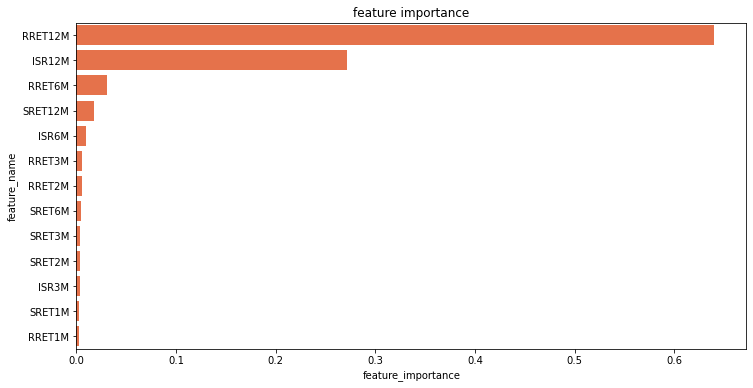

In [134]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': train_features.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt,color='#FF6631')
plt.title('feature importance')
plt.show()

In [142]:
def predict_at_k(data, model, k):
    user_ids = list()
    product_ids = list()
    ranks = list()
    
    for userId, df in data.groupby('Date'):
        
        pred = model.predict(df.loc[userId])
        productId = np.array(df.reset_index()['symbols'])
        topK_index = np.argsort(pred)[::-1][:k]
        product_ids.extend(list(productId[topK_index]))
        user_ids.extend([userId]*len(topK_index))
        ranks.extend(list(range(1, len(topK_index)+1)))

    results = pd.DataFrame({'rebalance_date': user_ids, 'symbol': product_ids, 'rank': ranks})    
    return results

predicted = predict_at_k(test_features, model, 469)

""" def coverage(preds,train_X_p):
  test_recs = preds['movieId'].nunique()
  train_movies = train_X_p['movieId'].nunique()
  return test_recs/train_movies """

" def coverage(preds,train_X_p):\n  test_recs = preds['movieId'].nunique()\n  train_movies = train_X_p['movieId'].nunique()\n  return test_recs/train_movies "

In [147]:
preds = []

for rebalanceId, df in test_features.groupby("Date"):
    pred = model.predict(df.loc[rebalanceId])
    preds.append(pred)

preds[0].shape


(469,)

In [159]:
best_performers = target_test[target_test["ISC12M"]==19]
best_performers = best_performers.reset_index()
best_performers

,Date,symbols,ISC12M
0,2019-10-31,APD,19.0
1,2019-10-31,ARE,19.0
2,2019-10-31,BF-B,19.0
3,2019-10-31,BHE,19.0
4,2019-10-31,CSGS,19.0
...,...,...,...
811,2022-07-29,TDW,19.0
812,2022-07-29,VLO,19.0
813,2022-07-29,WMB,19.0
814,2022-07-29,WMK,19.0


In [166]:
best_predicted_one_ahead = set(predicted[predicted["rebalance_date"]=="2019-10-31"]["symbol"].head(24))
best_predicted_one_ahead

{'AEP',
 'AZO',
 'CINF',
 'CMS',
 'CSGS',
 'CTAS',
 'EQR',
 'ETR',
 'FE',
 'HSY',
 'KIM',
 'KLAC',
 'NEE',
 'PEAK',
 'PG',
 'PHM',
 'PNM',
 'POR',
 'SHW',
 'SO',
 'SRE',
 'T',
 'UTI',
 'XEL'}

In [167]:
best_observed_one_ahead = set(best_performers[best_performers["Date"]=="2019-10-31"]["symbols"])
best_observed_one_ahead

{'APD',
 'ARE',
 'BF-B',
 'BHE',
 'CSGS',
 'DHI',
 'EFX',
 'ETR',
 'FISV',
 'HIG',
 'HSY',
 'KIM',
 'KLAC',
 'LMT',
 'MCO',
 'NEE',
 'PHM',
 'SHW',
 'SO',
 'SP',
 'SRE',
 'TGT',
 'TSN',
 'XRAY'}

In [168]:
best_observed_one_ahead.intersection(best_predicted_one_ahead)

{'CSGS', 'ETR', 'HSY', 'KIM', 'KLAC', 'NEE', 'PHM', 'SHW', 'SO', 'SRE'}

In [169]:
predicted

,rebalance_date,symbol,rank
0,2019-10-31,ETR,1
1,2019-10-31,SO,2
2,2019-10-31,NEE,3
3,2019-10-31,EQR,4
4,2019-10-31,HSY,5
...,...,...,...
15941,2022-07-29,MAS,465
15942,2022-07-29,MATW,466
15943,2022-07-29,MCO,467
15944,2022-07-29,MCY,468


In [170]:
predicted.shape[0]/predicted["symbol"].nunique()

34.0

In [173]:
predicted_relevancies = pd.pivot(
    predicted,
    index="rebalance_date",
    columns="symbol",
    values="rank"
) # The Lower the Rank, The Higher The Relevance

In [197]:
port_decisions = predicted_relevancies<25
port_decisions

symbol,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
rebalance_date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-11-29,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-12-31,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-01-31,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2020-02-28,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-03-31,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-04-30,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-05-29,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-06-30,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [178]:
port_decisions.iloc[-1]

symbol
A       False
AA      False
AAPL    False
ABC     False
ABT     False
        ...  
XRX     False
Y       False
YUM     False
ZBH     False
ZION    False
Name: 2022-07-29 00:00:00, Length: 469, dtype: bool

In [179]:
daily_rets = pd.read_csv(
    "../data/config/20220831_baseline_portfolio_daily_returns.csv",
    parse_dates=["Date"],
    index_col="Date"    
)

In [180]:
daily_rets

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-03,-0.002475,-0.010419,0.000885,-0.013060,-0.006757,-0.006139,-0.027333,0.013606,-0.006862,-0.005112,...,0.003057,0.016588,0.013250,-0.020014,-0.006456,0.001227,-0.008032,0.007014,0.010344,-0.005210
2006-10-04,0.024814,0.017548,0.016791,-0.009872,0.027483,0.016815,0.001081,0.000419,0.024932,0.002665,...,0.018796,0.007575,0.025064,0.005986,0.030325,0.000817,0.014756,0.029692,0.014819,0.007452
2006-10-05,-0.004238,-0.007297,0.015428,-0.016759,0.011123,-0.003713,0.009447,0.000000,0.030481,0.001898,...,0.005983,0.006941,0.013465,0.010151,-0.004906,-0.001632,0.008501,0.025632,0.000796,0.016793
2006-10-06,0.011854,-0.008152,-0.016691,-0.003452,-0.000786,0.018631,-0.010695,-0.004822,-0.001707,-0.005494,...,-0.011401,0.000574,-0.001748,-0.005544,0.008803,0.001635,-0.007542,-0.009372,-0.008489,-0.005112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-25,0.017506,0.014923,0.014774,0.004268,-0.004240,0.020898,0.025609,0.008081,0.026675,0.006058,...,0.010681,0.003737,0.020783,0.013158,0.009245,0.009687,0.008649,0.000939,0.010546,0.015523
2022-08-26,-0.045144,-0.037699,-0.028121,-0.037681,-0.056718,-0.050278,-0.014850,-0.029937,-0.056234,-0.015885,...,-0.005184,-0.028047,-0.030777,-0.016824,-0.005089,-0.011316,-0.018628,-0.019709,-0.024133,-0.007813
2022-08-29,-0.013552,-0.013690,0.008893,-0.000589,-0.015117,-0.017225,0.013399,-0.006388,-0.009915,0.004853,...,-0.003808,-0.007150,-0.005374,-0.020114,-0.009719,-0.006469,-0.014763,-0.008138,-0.010503,-0.022595


In [186]:
#from modules import performance_measures_helper as pms (PYTHONPATH issues, review)
monthly_rets = daily_rets.resample("BM").apply(
    lambda x: np.prod(x+1)-1
)

In [192]:
port_decisions

symbol,A,AA,AAPL,ABC,ABT,ACIW,ADBE,ADI,ADM,ADP,...,WWW,WY,XEL,XOM,XRAY,XRX,Y,YUM,ZBH,ZION
rebalance_date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-11-29,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2019-12-31,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-01-31,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-02-28,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2020-03-31,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-04-30,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-05-29,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020-06-30,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


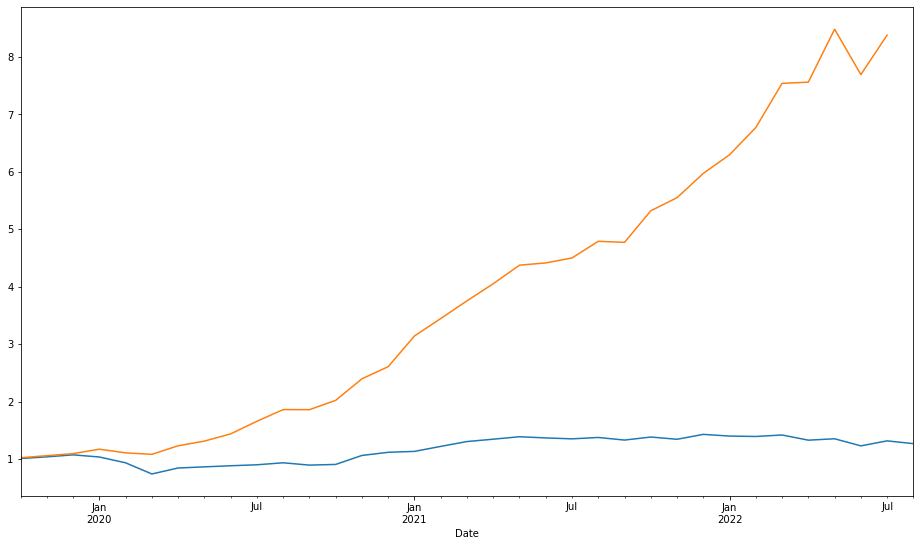

In [198]:
(1+monthly_rets[port_decisions.index[0]:].mean(axis=1)).cumprod().plot(figsize=(16,9));
(1+monthly_rets[port_decisions][port_decisions.index[0]:].mean(axis=1)).cumprod().plot(figsize=(16,9));

In [196]:
# In order to outperform baseline equally-weighted, we remark that almost 75% of accuracy on portfolio selection must be achieved...